# Map 2D data

This notebook describes an algorithm for how to map 2D data using the (george package), which is based on Gaussian Process Regression  
[https://george.readthedocs.io/en/latest/]. 

Gaussian Processes (GP) are a supervised learning method designed to solve regression and probabilistic classification problems.

An introduction to GP regression can be found here: https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb




To test the function we choose to use temperature data from Argo floats similar to Kuessler and Stein (2018)  
https://doi.org/10.1098/rspa.2018.0400


The function will perform the following steps 
    
* Load a subset of Argo data using argopy
* Linearly interpolate onto pressure levels and select one pressure level for use
* Compute the mean state
* Subtract the mean state from the data to get the anomalies
* The GP is applied to the anomaly data



In [1]:
%matplotlib inline
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':14})

In [4]:
# Define region of interest to interpolate

ilat = 40
flat = 60
ilon = -50
flon = -30
idepth = 100
fdepth = 300
idate = "2010-01-01"
fdate = "2012-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)

In [5]:
argo_profiles = ds.argo.point2profile() # Convert points to profiles and 
argo_interp = argo_profiles.argo.interp_std_levels([250]) # Interpolate to pressure levels
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]] #select relevant variables

In [6]:
selected_vars

<xarray.Dataset>
Dimensions:            (N_PROF: 4365, PRES_INTERPOLATED: 1)
Coordinates:
    LATITUDE           (N_PROF) float64 46.99 57.87 41.68 ... 59.53 47.54 56.85
    LONGITUDE          (N_PROF) float64 -33.56 -43.03 -48.08 ... -42.57 -43.84
    TIME               (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-1...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
  * N_PROF             (N_PROF) int64 1674 1467 790 1437 ... 1031 2455 2885 2711
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 13.181076 ... 3.96...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/14
    Fetched_constraints:  phy_[x=-50.00/-30.00; y=40.00/60.00; z=100.0/300.0;...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [4]:
# Compute the background mean

In [7]:
# Define some functions

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from typing import Iterable


def get_harmonics(nharmonics, time, period=365):
    """Compute the requested number of harmonics
    for a set time.
    
    Parameters
    ----------
    nharmonics : int
        Number of harmonics to compute
    time : int, Iterable
        Time point within period of oscillation.
        This can be either a single int or a 1d-array
    period : int, optional
        Period of oscillation
        
    Returns
    -------
    harmonics: 2d-array
        Array of shape (len(time), nharmonics*2) where
        nharmonics*2 accounts for the cos and sin terms.
    """
    harmonics = np.arange(1, nharmonics + 1)
    if isinstance(time, Iterable):
        time = np.asarray(time)[:, np.newaxis]
        harmonics = harmonics[np.newaxis, :]
    phase = 2 * np.pi * harmonics * time / period
    return np.concatenate([np.cos(phase), np.sin(phase)], axis=-1)


def build_basis(lat, lon, time, nharmonics):
    """Build the 2d local polynomial regression basis
    according to Park2020
    """
    local_polynomlial_reg = np.ones((lat.size, 6 + nharmonics * 2))
    local_polynomlial_reg[:, 1] = lon
    local_polynomlial_reg[:, 2] = lat
    local_polynomlial_reg[:, 3] = lon * lat
    local_polynomlial_reg[:, 4] = lon ** 2
    local_polynomlial_reg[:, 5] = lat ** 2
    local_polynomlial_reg[:, 6:] = get_harmonics(nharmonics, time)
    return local_polynomlial_reg


def find_mean_state(lat, lon, time, data, nharmonics=2):
    """Find the mean state
    
    Parameters
    ----------
    lat, lon, time, data : 1d-array
        Arrays containing latitude, longitude, day of year and
        data.
    nharmonics: int, optional
        Number of harmonics to add into the basis functions
    """
    return lsq_linear(build_basis(lat, lon, time, nharmonics), data)

In [8]:
Taxis = np.zeros(len(selected_vars.TIME.values))
Taxis = selected_vars.TIME.values.astype(np.int64)/1e9/24/3600
Taxis # this gives number of days since 1970

array([14610.15833333, 14610.22708333, 14610.32847222, ...,
       15339.18611111, 15339.30369213, 15339.8009375 ])

In [9]:
14610/360

40.583333333333336

In [10]:
# Fit the mean

# We solve for the parameters mean state by solving a least squares problem,
# Ax=b , where A is the basis vectors, x are its parameters and b is the mean state+ anomalies
mean_state_fit = find_mean_state(
    selected_vars.LATITUDE,
    selected_vars.LONGITUDE,
    # selected_vars.TIME.dt.dayofyear, # this will not work because it will make the time in each year to be the same
    Taxis,
    selected_vars.TEMP.data.flatten(),
)

# now we predict the mean state (essentially only the part of the data that is mean, discarding the anomalies - which will be modeled by the GP lates)
mean_state = np.matmul(build_basis(selected_vars.LATITUDE, selected_vars.LONGITUDE, Taxis, 2), mean_state_fit.x)



In [55]:
# Get the anomaly
Anomaly = selected_vars.TEMP.squeeze() - mean_state
Anomaly

<xarray.DataArray 'TEMP' (N_PROF: 4365)>
array([ 2.19205413, -1.07889045,  3.40619863, ..., -0.83588418,
       -3.70752948, -0.80044793])
Coordinates:
    LATITUDE           (N_PROF) float64 46.99 57.87 41.68 ... 59.53 47.54 56.85
    LONGITUDE          (N_PROF) float64 -33.56 -43.03 -48.08 ... -42.57 -43.84
    TIME               (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-1...
    PRES_INTERPOLATED  int64 250
  * N_PROF             (N_PROF) int64 1674 1467 790 1437 ... 1031 2455 2885 2711

In [8]:
# Add plot here (world map? )

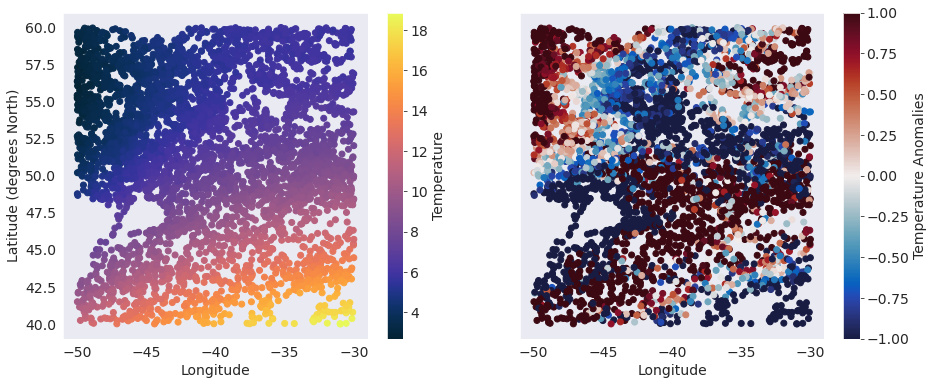

In [14]:
# Plot
# This plot has all the data, not just the data at certain time (so it mixes seasonal changes etc)

import cmocean.cm as cmo

fig, ax = plt.subplots(1,2, figsize=[15,6],sharey=True)
cs1 = ax[0].scatter(selected_vars.LONGITUDE,selected_vars.LATITUDE,c=mean_state, cmap=cmo.thermal)

cbar=plt.colorbar(cs1,ax=ax[0])
cbar.set_label('Temperature')


cs2 = ax[1].scatter( selected_vars.LONGITUDE,selected_vars.LATITUDE,c=Anomaly, cmap=cmo.balance, vmin=-1, vmax=1)
cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')

ax[0].set_ylabel('Latitude (degrees North)')

ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('Longitude')

fig.savefig('SPNA_mean+anom.png')
        

Text(0, 0.5, 'Mean temp')

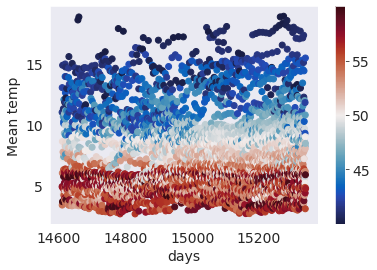

In [15]:
plt.scatter(Taxis, mean_state, c=selected_vars.LATITUDE, cmap=cmo.balance)
plt.colorbar()

plt.xlabel('days')
plt.ylabel('Mean temp')

# Check if the mean has some seasonal cycle

In [16]:
# Also make some predictions on a regular grid (for ease of plotting)

lat = np.linspace(ilat, flat, 60) # can change that 50 if you want predictions at finer scales
lon = np.linspace(ilon, flon, 50)

llon, llat = np.meshgrid(lon, lat)

# we need reshape the above into single column vectors, because that is expected. 
llons = llon.reshape(-1)
llats = llat.reshape(-1)

mean_state_s = np.matmul(build_basis(llats, llons, (2011-1970)*365, 2), mean_state_fit.x)
# chose a particular time to get a prediction at a certain time
# all the above thing does is Ax, which gives us b - the mean state. 
# you could also use the above matrix multiply to generate a time series at a location. 

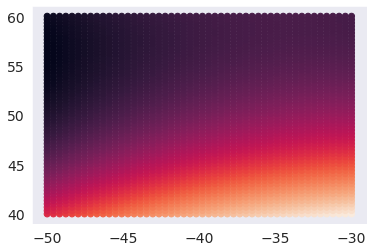

In [17]:
plt.scatter(llons, llats, c= mean_state_s.T)

In [18]:
# Could also regrid 
# we can regrid and create this 2D array 
# we know the size is 50X50, because that is what we chose above.
mean_state_g = mean_state_s.reshape(60,50)

<ipython-input-19-9746f923f4b8>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(llon, llat, mean_state_g)


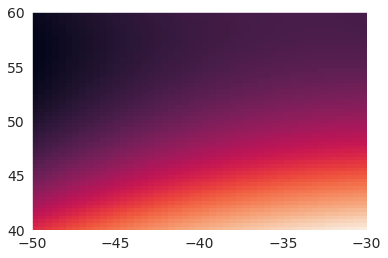

In [19]:
plt.pcolormesh(llon, llat, mean_state_g)

In [20]:
xmean_state = xr.DataArray(mean_state_g, dims= ["lat","lon"],coords=[ lat,lon])

In [21]:
xmean_state

<xarray.DataArray (lat: 60, lon: 50)>
array([[11.71678469, 11.94788029, 12.17551292, ..., 18.83480091,
        18.90313664, 18.9680094 ],
       [11.35532009, 11.58478411, 11.81078515, ..., 18.39665196,
        18.46335611, 18.52659728],
       [11.0013953 , 11.22922774, 11.4535972 , ..., 17.96604282,
        18.03111538, 18.09272497],
       ...,
       [ 3.1468477 ,  3.28494313,  3.41957558, ...,  5.89385579,
         5.86919135,  5.84106393],
       [ 3.21515258,  3.35161642,  3.48461729, ...,  5.88547631,
         5.85918029,  5.82942129],
       [ 3.29099726,  3.42582953,  3.55719881, ...,  5.88463665,
         5.85670904,  5.82531846]])
Coordinates:
  * lat      (lat) float64 40.0 40.34 40.68 41.02 ... 58.98 59.32 59.66 60.0
  * lon      (lon) float64 -50.0 -49.59 -49.18 -48.78 ... -30.82 -30.41 -30.0

In [10]:
# Now we have the anomaly data that the GP will be computed on


In [22]:
import pandas as pd

# The lon,lat,time coordinates need to be in a specific format for george

Input_coordinates=xr.concat((selected_vars.LONGITUDE,selected_vars.LATITUDE,selected_vars.TIME.dt.dayofyear),pd.Index(['lon','lat','time'], name="coordinate")).T

In [24]:
Input_coordinates

<xarray.DataArray 'LONGITUDE' (N_PROF: 4365, coordinate: 3)>
array([[-33.55699921,  46.99200058,   1.        ],
       [-43.03499985,  57.87200165,   1.        ],
       [-48.07699585,  41.67699814,   1.        ],
       ...,
       [-36.235     ,  59.527     , 365.        ],
       [-42.566     ,  47.536     , 365.        ],
       [-43.836     ,  56.852     , 365.        ]])
Coordinates:
    LONGITUDE   (N_PROF) float64 -33.56 -43.03 -48.08 ... -36.24 -42.57 -43.84
    TIME        (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-12-31T19...
    LATITUDE    (N_PROF) float64 46.99 57.87 41.68 54.15 ... 59.53 47.54 56.85
  * N_PROF      (N_PROF) int64 1674 1467 790 1437 897 ... 74 1031 2455 2885 2711
  * coordinate  (coordinate) object 'lon' 'lat' 'time'

In [25]:
Input_coordinates[:,2]

<xarray.DataArray 'LONGITUDE' (N_PROF: 4365)>
array([  1.,   1.,   1., ..., 365., 365., 365.])
Coordinates:
    LONGITUDE   (N_PROF) float64 -33.56 -43.03 -48.08 ... -36.24 -42.57 -43.84
    TIME        (N_PROF) datetime64[ns] 2010-01-01T03:48:00 ... 2011-12-31T19...
    LATITUDE    (N_PROF) float64 46.99 57.87 41.68 54.15 ... 59.53 47.54 56.85
  * N_PROF      (N_PROF) int64 1674 1467 790 1437 897 ... 74 1031 2455 2885 2711
    coordinate  <U4 'time'

In [27]:
import george as grg

Choose a kernel (covariance) function to model these data, assume a zero mean model

In [30]:
# Define lengthscale

Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

#test larger length scales
Lxscale = 180e3*np.sin(2*np.pi/360*50)
Lyscale = 180e3

# Define kernel (covariance function)
# A simple exponential squared kernel is used, assuming isentropy. 
# There are a number of kernels that can be used. Here we are testing 2:
# 1) the expontential squared kernel: kernel_argo_expsq
# 2) the Matern 3/2 kernel: kernel_argo_matern32

# Since we want to learn anisotropy in the data anomalies, which is not aligned with lon-lat,
# we have to allow for a non-diagonal matrix C in the definition of distance. 
# Let's be our first guess to be a diagonal matrix C, though.

kernel_argo_expsq = np.var(Anomaly).values*grg.kernels.ExpSquaredKernel(
                                            [
                                                [100e3**2/Lxscale**2,0,0],                
                                                [0,100e3**2/Lyscale**2,0], 
                                                [0,0,30**2]
                                            ], ndim=3)
kernel_argo_matern32 = np.var(Anomaly).values*grg.kernels.Matern32Kernel(
                                            [
                                                [100e3**2/Lxscale**2,0,0],                
                                                [0,100e3**2/Lyscale**2,0], 
                                                [0,0,30**2]
                                            ], ndim=3)

In [31]:
# Now let us set up the GP. 

gp_argo_expsq = grg.GP(kernel_argo_expsq)
gp_argo_matern32 = grg.GP(kernel_argo_matern32)

In [32]:
gp_argo_expsq.compute(Input_coordinates, 0.01) # 0.01 is an estimated observational error/ noise
gp_argo_matern32.compute(Input_coordinates, 0.01)

In [56]:
# Define some test grid points

#test_pts_argo = np.array(np.meshgrid(np.linspace(ilon,flon,30), 
#                       np.linspace(ilat,flat,30),
#                        np.linspace(0,365,30))).reshape(3,-1).T

test_pts_argo = np.array(np.meshgrid(np.linspace(ilon,flon,30),     #only one time value - speeds up the prediction
                       np.linspace(ilat,flat,30),
                        150.0)).reshape(3,-1).T

test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] )
test_pts_argo

<xarray.DataArray (test_pt_num: 900, coordinate: 3)>
array([[-50.        ,  40.        , 150.        ],
       [-49.31034483,  40.        , 150.        ],
       [-48.62068966,  40.        , 150.        ],
       ...,
       [-31.37931034,  60.        , 150.        ],
       [-30.68965517,  60.        , 150.        ],
       [-30.        ,  60.        , 150.        ]])
Coordinates:
  * test_pt_num  (test_pt_num) int64 0 1 2 3 4 5 6 ... 894 895 896 897 898 899
  * coordinate   (coordinate) <U4 'lon' 'lat' 'time'

In [38]:
pred_argo_expsq, pred_var_argo_expsq = gp_argo_expsq.predict(Anomaly, test_pts_argo, return_var=True)
pred_argo_matern32, pred_var_argo_matern32 = gp_argo_matern32.predict(Anomaly, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo_expsq = xr.DataArray(pred_argo_expsq,  dims={"test_pt_num"})
pred_var_argo_expsq = xr.DataArray(pred_var_argo_expsq,  dims={"test_pt_num"})

pred_argo_matern32 = xr.DataArray(pred_argo_matern32,  dims={"test_pt_num"})
pred_var_argo_matern32 = xr.DataArray(pred_var_argo_matern32,  dims={"test_pt_num"})

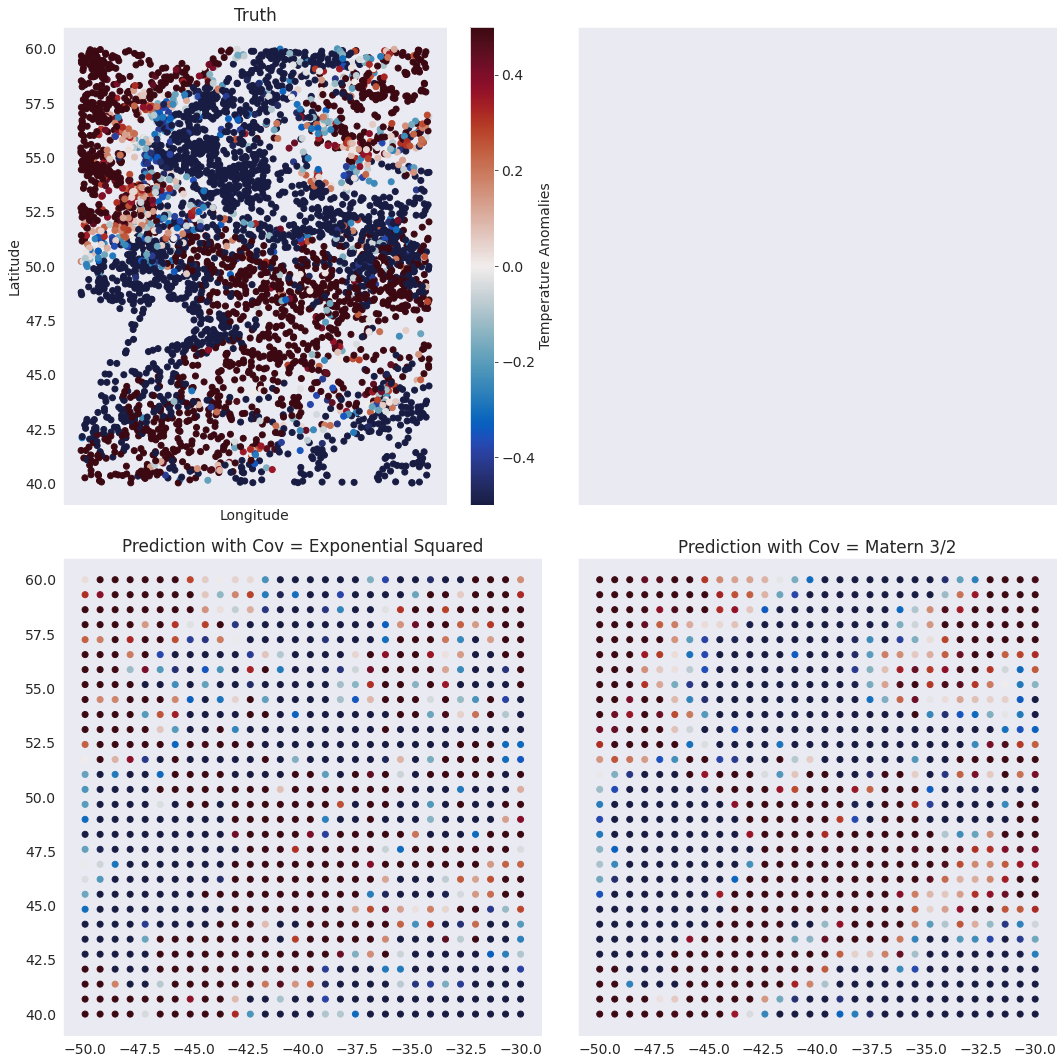

In [43]:
x_sel = Input_coordinates
y_sel = Anomaly

fig,ax=plt.subplots(2,2,figsize=(15,15),sharex=True,sharey=True)

cs=ax[0,0].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap=cmo.balance)
#ax[0].set_xlim(-50.5,-30.5)
ax[0,0].set_xlabel('Longitude')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_title('Truth')

cs2=ax[1,0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo_expsq, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1,0].set_title('Prediction with Cov = Exponential Squared')

cs3=ax[1,1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo_matern32, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1,1].set_title('Prediction with Cov = Matern 3/2')


cbar=plt.colorbar(cs,ax=ax[0,0])
cbar.set_label('Temperature Anomalies')


plt.tight_layout()

In [44]:
# Compute the Maximum Likelihood

print("Initial ln-likelihood for Cov = Expontential Sqared: {0:.2f}".format(gp_argo_expsq.log_likelihood(Anomaly)))
print("Initial ln-likelihood for Cov = Matern 3/2: {0:.2f}".format(gp_argo_matern32.log_likelihood(Anomaly)))

Initial ln-likelihood for Cov = Expontential Sqared: -42726.43
Initial ln-likelihood for Cov = Matern 3/2: -7751.15


Use Scipys optimize function to fit the maximum likelihood parameters 

In [47]:
from scipy.optimize import minimize


def neg_ln_like_argo_expsq(p):
    gp_argo_expsq.set_parameter_vector(p)
    return -gp_argo_expsq.log_likelihood(Anomaly)

def grad_neg_ln_like_argo_expsq(p):
    gp_argo_expsq.set_parameter_vector(p)
    return -gp_argo_expsq.grad_log_likelihood(Anomaly)

def neg_ln_like_argo_matern32(p):
    gp_argo_matern32.set_parameter_vector(p)
    return -gp_argo_matern32.log_likelihood(Anomaly)

def grad_neg_ln_like_argo_matern32(p):
    gp_argo_matern32.set_parameter_vector(p)
    return -gp_argo_matern32.grad_log_likelihood(Anomaly)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [48]:
%time result_argo_expsq = minimize(neg_ln_like_argo_expsq,gp_argo_expsq.get_parameter_vector(), jac=grad_neg_ln_like_argo_expsq)

CPU times: user 24min 22s, sys: 2min 44s, total: 27min 6s
Wall time: 11min 18s


In [49]:
%time result_argo_matern32= minimize(neg_ln_like_argo_matern32,gp_argo_matern32.get_parameter_vector(), jac=grad_neg_ln_like_argo_matern32)


CPU times: user 10min 46s, sys: 1min 41s, total: 12min 27s
Wall time: 6min 22s


In [50]:
# Optimized likelihood

gp_argo_expsq.set_parameter_vector(result_argo_expsq.x)
print("\nFinal ln-likelihood for Cov = Exponential Squared: {0:.2f}".format(gp_argo_expsq.log_likelihood(Anomaly)))

gp_argo_matern32.set_parameter_vector(result_argo_matern32.x)
print("\nFinal ln-likelihood for Cov = Matern 3/2: {0:.2f}".format(gp_argo_matern32.log_likelihood(Anomaly)))



Final ln-likelihood for Cov = Exponential Squared: -8724.60

Final ln-likelihood for Cov = Matern 3/2: -7717.56


In [51]:
# Here the new prediction is made using the MLE parameter estimates

pred_MLE_argo_expsq, pred_var_MLE_argo_expsq = gp_argo_expsq.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo_expsq = xr.DataArray(pred_MLE_argo_expsq,  dims={"test_pt_num"})
pred_var_MLE_argo_expsq = xr.DataArray(pred_var_MLE_argo_expsq,  dims={"test_pt_num"})

pred_MLE_argo_matern32, pred_var_MLE_argo_matern32 = gp_argo_expsq.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo_matern32 = xr.DataArray(pred_MLE_argo_matern32,  dims={"test_pt_num"})
pred_var_MLE_argo_matern32 = xr.DataArray(pred_var_MLE_argo_matern32,  dims={"test_pt_num"})

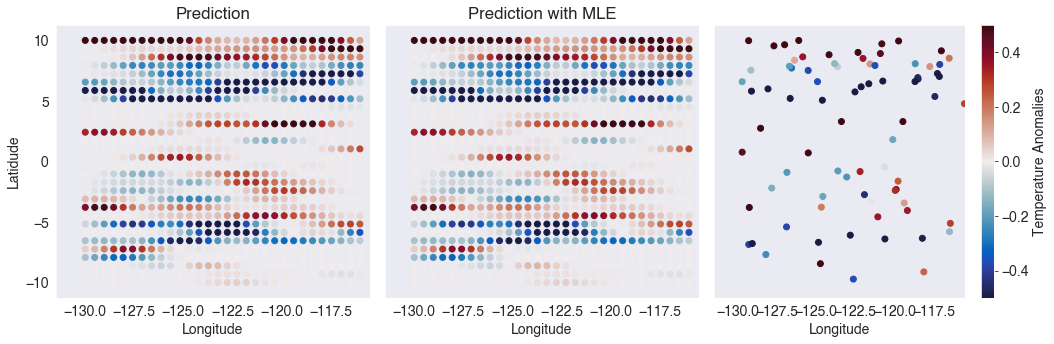

In [66]:
fig,ax= plt.subplots(3,2,figsize=(15,5),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latidude')
ax[0].set_title('Prediction')

cs2=ax[1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap=cmo.balance)
ax[1].set_xlabel('Longitude')
ax[1].set_title('Prediction with MLE')


x_sel = Input_coordinates.where(np.logical_and(Input_coordinates.sel(coordinate='time')<155.0 , 
                               Input_coordinates.sel(coordinate='time')>145.0), 
                                drop='true')

y_sel = Anomaly.where(np.logical_and(Input_coordinates.sel(coordinate='time')<155.0 , 
                               Input_coordinates.sel(coordinate='time')>145.0), 
                                drop='true')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, cmap='RdBu_r')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')


cs=ax[2].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap=cmo.balance)

ax[2].set_xlabel('Longitude')
cbar=plt.colorbar(cs,ax=ax[2])
cbar.set_label('Temperature Anomalies')
ax[2].set_label('Truth')
ax[2].set_xlim(-131.5, -115.5)

plt.tight_layout()



In [53]:
# Did the MLE change the length scales that we had guessed?
print('Expontential Squared')
print(gp_argo_expsq.parameter_names)
print(np.exp(gp_argo_expsq.parameter_vector))

print('Matern 3/2')
print(gp_argo_matern32.parameter_names)
print(np.exp(gp_argo_matern32.parameter_vector))

Expontential Squared
('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_L_0_0', 'kernel:k2:metric:L_0_1', 'kernel:k2:metric:L_0_2', 'kernel:k2:metric:log_L_1_1', 'kernel:k2:metric:L_1_2', 'kernel:k2:metric:log_L_2_2')
[1.00000000e+00 1.25000000e-12 1.42413396e+00 9.11448498e-02
 1.00812095e+00 5.55292725e-01 3.77802960e-01 9.98939600e-01
 2.95425434e+01]
Matern 3/2
('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_L_0_0', 'kernel:k2:metric:L_0_1', 'kernel:k2:metric:L_0_2', 'kernel:k2:metric:log_L_1_1', 'kernel:k2:metric:L_1_2', 'kernel:k2:metric:log_L_2_2')
[1.00000000e+00 1.25000000e-12 1.43505964e+00 7.75201257e-01
 1.00379801e+00 5.55783194e-01 6.90181265e-01 9.99315296e-01
 2.98379713e+01]


In [54]:
print('Expontential Squared')
print('Lx(km)='+str((np.exp(gp_argo_expsq.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo_expsq.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo_expsq.parameter_vector[5]))**0.5))

print('Matern 3/2')
print('Lx(km)='+str((np.exp(gp_argo_matern32.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo_matern32.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo_matern32.parameter_vector[5]))**0.5))
# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Expontential Squared
Lx(km)=41.62867025853391
Ly(km)=180.72940744309946
Timescale(km)=0.7451796598365467
Matern 3/2
Lx(km)=121.40419842033236
Ly(km)=180.34149688404048
Timescale(km)=0.7455086813139954
